In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '5'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [5]


In [ ]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

from jax import jit

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax
import diffrax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import sys

from blackjax import normal_random_walk
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

from jaxtyping import Array


from bamojax.base import Model
from bamojax.samplers import gibbs_sampler, mcmc_sampler
from bamojax.inference import SMCInference, MCMCInference


print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


# Lotka-Volterra dynamics

Let
$$
\frac{\text{d}x}{\text{d}t} = \alpha x - \beta x y \enspace,
$$ and
$$
\frac{\text{d}y}{\text{d}t} = \delta x y - \gamma y \enspace.
$$ 

We assume our observations are corrupted by i.i.d. Gaussian noise with standard deviation $\sigma$, such that
$$
    y(t) \sim \mathcal{N}\left(\left(\int x(\tau \text{d}\tau\right)(t), \sigma\right)
$$

In [3]:
from diffrax import diffeqsolve, ODETerm, Dopri5, Tsit5

@jit
def f_lotka_volterra(t, state, args):
    """
        
    """
    x, y = state
    alpha, beta, gamma, delta = args 
    dx1dt = alpha*x - beta*x*y
    dx2dt = -gamma*y + delta*x*y
    return jnp.array([dx1dt, dx2dt])

#

Test dynamics

(500, 2)


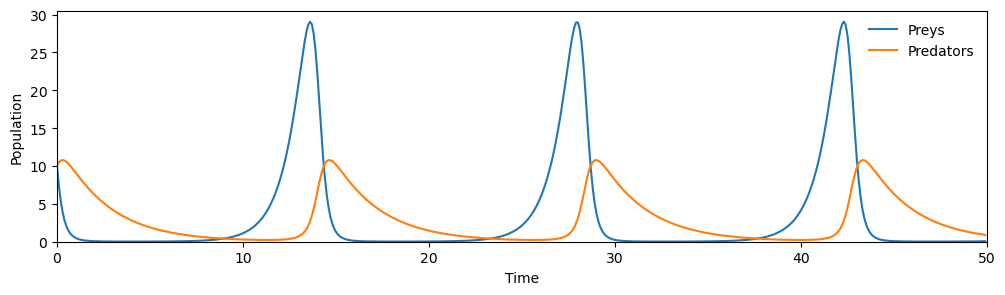

In [4]:
# x = prey
# y = predator
# alpha, beta, gamma, delta: prey growth rate, prey death rate, predator death rate, predator growth rate

default_params = jnp.asarray([1.1, 0.4, 0.4, 0.1])

y0 = jnp.asarray([10, 10])

t0 = 0.0
t1 = 50
dt = 0.1

solver = Tsit5()

solution = diffeqsolve(
    ODETerm(f_lotka_volterra),
    solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=y0,
    args=default_params,
    max_steps=10000,
    saveat=diffrax.SaveAt(ts=jnp.arange(t0, t1, dt))
)

t = solution.ts
y = solution.ys
T, D = y.shape
print(y.shape)

plt.figure(figsize=(12, 3))
plt.plot(t, y, label=['Preys', 'Predators'])
plt.xlim([t0, t1])
plt.ylim(bottom=0)
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend(frameon=False);

Actual dataset

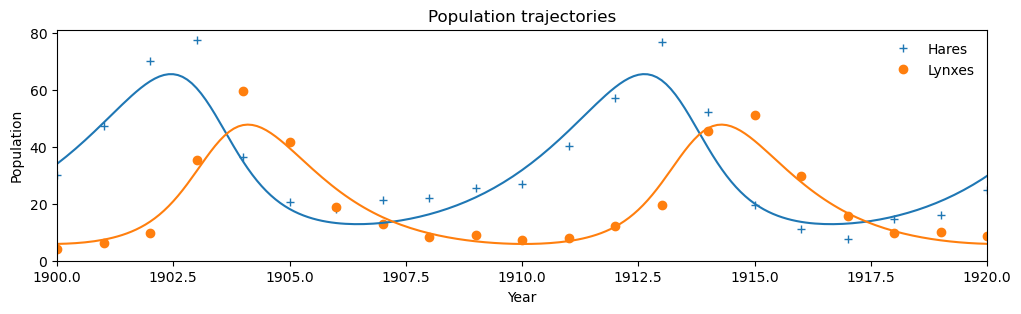

In [5]:
time = jnp.arange(1900., 1921., 1)  # if we put this in a jax numpy array, it'll be a tracer later which we cannot use for shapes
lynx = jnp.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
hare = jnp.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])

Y = jnp.stack([hare, lynx]).T

mle = dict(alpha=0.52, beta=0.026, gamma=0.84, delta=0.026, Y0=jnp.array([34.0, 5.9]))
args = jnp.array([mle['alpha'], mle['beta'], mle['gamma'], mle['delta']])

t0, t1, dt = 1900, 1921, 0.1

solution = diffeqsolve(
    ODETerm(f_lotka_volterra),
    solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=mle['Y0'],
    args=args,
    max_steps=1000,
    saveat=diffrax.SaveAt(ts=jnp.arange(t0, t1, dt))
)

t = solution.ts
y = solution.ys
T, D = y.shape

plt.figure(figsize=(12, 3))
plt.plot(time, hare, '+', color='tab:blue', label='Hares')
plt.plot(time, lynx, 'o', color='tab:orange', label='Lynxes')

plt.plot(t, y)
plt.xlim([1900, 1920])
plt.ylim(bottom=0)
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(frameon=False)
plt.title('Population trajectories');

In [6]:
# t0, t1, dt = time[0], time[-1], time[1] - time[0]
t0, t1, dt = 1900, 1921, 1

solver = Tsit5()

def lv_link_fn(alpha, beta, gamma, delta, y0, sigma):
    args = jnp.asarray([alpha, beta, gamma, delta])
    solution = diffeqsolve(
        ODETerm(f_lotka_volterra),
        solver,
        t0=t0,
        t1=t1,
        dt0=dt,
        y0=y0,
        args=args,
        max_steps=1000,
        saveat=diffrax.SaveAt(ts=jnp.arange(t0, t1, dt)) # SaveAt(ts=time) instead?
    )
    y_ = jnp.nan_to_num(solution.ys, nan=1e6)  # important fix
    return dict(loc=y_, scale=sigma)

#    

LV = Model('Bayesian Lotka-Volterra', verbose=True)
y0_node = LV.add_node('Y0', distribution=dx.Normal, parents=dict(loc=jnp.array([30., 4.]), scale=1*jnp.ones(2)))
alpha_node = LV.add_node('alpha', distribution=dx.Uniform(low=0.0, high=1.0))
beta_node = LV.add_node('beta', distribution=dx.Uniform(low=0.0, high=0.1))
gamma_node = LV.add_node('gamma', distribution=dx.Uniform(low=0.5, high=1.0))
delta_node = LV.add_node('delta', distribution=dx.Uniform(low=0.0, high=0.1))
sigma_node = LV.add_node('sigma', distribution=dx.Uniform(low=0.0, high=10.0))

y_node = LV.add_node('Y', observations=Y, distribution=dx.Normal, parents=dict(alpha=alpha_node, beta=beta_node, gamma=gamma_node, delta=delta_node, y0=y0_node, sigma=sigma_node), link_fn=lv_link_fn)

Adding node (loc_Y0)
Adding node (scale_Y0)
Adding node (Y0)
Add edge (loc_Y0) -> (Y0)
Add edge (scale_Y0) -> (Y0)
Adding node (alpha)
Adding node (beta)
Adding node (gamma)
Adding node (delta)
Adding node (sigma)
Adding node (Y)
Add edge (alpha) -> (Y)
Add edge (beta) -> (Y)
Add edge (gamma) -> (Y)
Add edge (delta) -> (Y)
Add edge (Y0) -> (Y)
Add edge (sigma) -> (Y)


According to the PyMC implementation we expect rougly these parameter values: $\alpha=0.48, \beta=0.03, \gamma=0.94, \delta=0.03, y_0=[34.95, 3.84]^\top, \sigma=4.11$.

### Gibbs-in-SMC

Many NaNs in the likelihood when we draw from the prior. Still, the values we get are mostly not that insane.

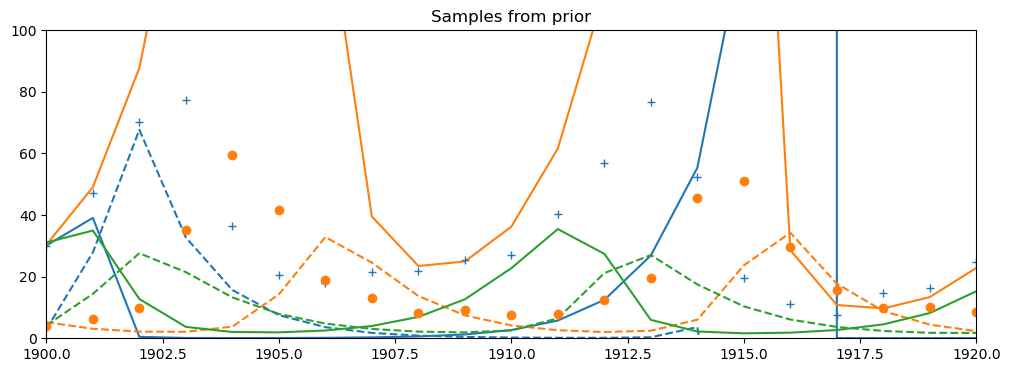

In [7]:
def visualize_trajectory(ax, sample, time, color):
    args = jnp.asarray([sample['alpha'], sample['beta'], sample['gamma'], sample['delta']])
    t0, t1, dt = time[0], time[-1], time[1] - time[0]
    solution = diffeqsolve(
        ODETerm(f_lotka_volterra),
        solver,
        t0=t0,
        t1=t1,
        dt0=dt,
        y0=sample['Y0'],
        args=args,
        max_steps=1000,
        saveat=diffrax.SaveAt(ts=time)
    )
    y_ = jnp.nan_to_num(solution.ys, nan=1e-6)
    # ll = jnp.sum(dx.Normal(loc=y_, scale=sample['sigma']).log_prob(Y))
    t = solution.ts
    ax.plot(t, y_[:, 0], label=['Hare'], ls='-', color=color)
    ax.plot(t, y_[:, 1], label=['Lynx'], ls='--', color=color)
    
#
num_samples = 20
key = jrnd.PRNGKey(42)
keys = jrnd.split(key, num_samples)

prior_samples = jax.vmap(LV.sample_prior)(keys)
loglikelihood_fn = LV.loglikelihood_fn()

test_params = dict(alpha=0.48, beta=0.02, gamma=0.93, delta=0.03, Y0=jnp.array([35., 3.9]))

plt.figure(figsize=(12, 4))
ax = plt.gca()
for i in range(3):
    select_sample = jax.tree.map(lambda l: l[i], prior_samples)
    visualize_trajectory(ax, select_sample, time, color=ax._get_lines.get_next_color())

ax.plot(time, hare, '+', color='tab:blue', label='Hares')
ax.plot(time, lynx, 'o', color='tab:orange', label='Lynxes')

ax.set_ylim([0, 100])
ax.set_xlim([1900, 1920])
ax.set_title('Samples from prior');


In [ ]:
%%time
key = jrnd.PRNGKey(42)

step_fns = dict(alpha=normal_random_walk, beta=normal_random_walk, gamma=normal_random_walk, delta=normal_random_walk, Y0=normal_random_walk, sigma=normal_random_walk)
step_fn_params = dict(alpha=dict(sigma=1e-3), beta=dict(sigma=1e-3), gamma=dict(sigma=1e-3), delta=dict(sigma=1e-3), Y0=dict(sigma=0.01*jnp.eye(2)), sigma=dict(sigma=0.01))

gibbs = gibbs_sampler(LV, step_fns=step_fns, step_fn_params=step_fn_params)

num_mcmc_steps = 10
num_particles = 1000

key, subkey = jrnd.split(key)


engine = SMCInference(model=LV, num_chains=1, return_diagnostics=True, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps)
key, subkey = jrnd.split(key)
result = engine.run(key=subkey)

final_state = result['final_state']
n_iter = result['n_iter']
lml = result['lml']
final_info = result['final_info']

for node in final_info.update_info:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

print('Model marginal likelihood:', lml)

In [ ]:
def plot_posterior(samples):
    _, axes = plt.subplots(nrows=2, ncols=4, constrained_layout=True, figsize=(16, 6))
    for i, param in enumerate(['alpha', 'beta', 'gamma', 'delta']):
        axes[0, i].hist(samples[param], density=True, bins=30)
        axes[0, i].set_title(fr'$\{param}$')
    axes[1, 0].hist(samples['Y0'][:, 0], density=True, bins=30)
    axes[1, 0].set_title(r'$x_0$')
    axes[1, 1].hist(samples['Y0'][:, 1], density=True, bins=30)
    axes[1, 1].set_title(r'$y_0$')
    axes[1, 2].hist(samples['sigma'], density=True, bins=30)
    axes[1, 2].set_title(r'$\sigma$')
    axes[1, 3].axis('off');
    return axes

#
_ = plot_posterior(final_state.particles)

Note that the PyMC example only draws 50 samples because of the speed challenge!

In [ ]:
%%time



cold_nuts_parameters = dict(step_size=0.5, inverse_mass_matrix=0.0001*jnp.eye(m))
nuts_kernel = mcmc_sampler(model=model, mcmc_kernel=blackjax.nuts, mcmc_parameters=cold_nuts_parameters)

engine = MCMCInference(model=LV, mcmc_kernel=nuts_kernel, num_samples=2000, num_burn=0, num_warmup=1000)
result = engine.run(key=jrnd.PRNGKey(0))

nuts_states = engine['states']

_ = plot_posterior(nuts_states)


warm parameters {'step_size': Array(0.09364266, dtype=float64, weak_type=True), 'inverse_mass_matrix': Array([8.32898999e-01, 2.57482806e-01, 9.67582648e-04, 1.26602612e-05,
       1.29050457e-05, 2.93414217e-03, 3.54661501e-01], dtype=float64)}
CPU times: user 56min 6s, sys: 10.6 s, total: 56min 17s
Wall time: 56min 28s


(0.0, 1.0, 0.0, 1.0)

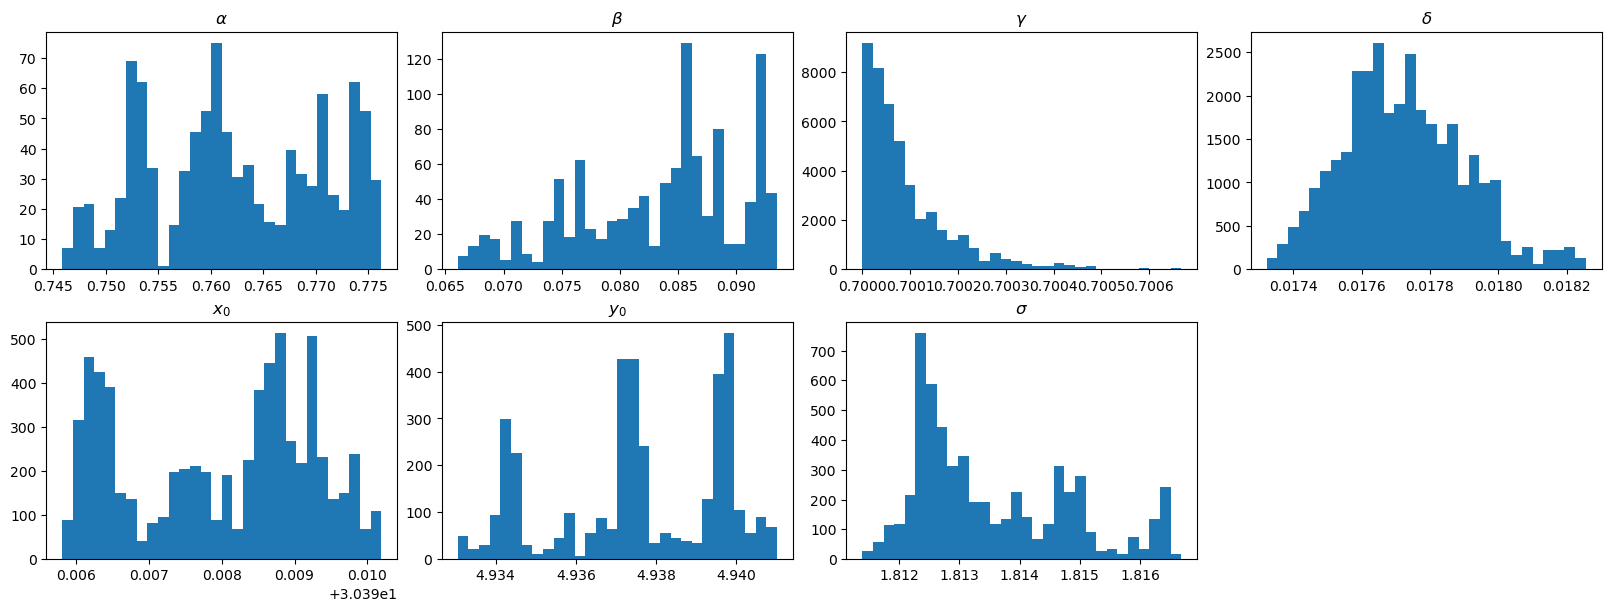

In [ ]:
def plot_posterior(samples):
    _, axes = plt.subplots(nrows=2, ncols=4, constrained_layout=True, figsize=(16, 6))
    for i, param in enumerate(['alpha', 'beta', 'gamma', 'delta']):
        axes[0, i].hist(samples[param], density=True, bins=30)
        axes[0, i].set_title(fr'$\{param}$')
    axes[1, 0].hist(samples['Y0'][:, 0], density=True, bins=30)
    axes[1, 0].set_title(r'$x_0$')
    axes[1, 1].hist(samples['Y0'][:, 1], density=True, bins=30)
    axes[1, 1].set_title(r'$y_0$')
    axes[1, 2].hist(samples['sigma'], density=True, bins=30)
    axes[1, 2].set_title(r'$\sigma$')
    axes[1, 3].axis('off');
    return axes

#